In [1]:
import csv
import cv2
import numpy as np
import sklearn
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import time

In [7]:
_time = time.time()
lines = []
with open("data/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
lines = lines[1:]
print("lines",len(lines))#passed
print("0:",lines[0])
print("0:",lines[1])
print("_time ",(time.time() - _time))

lines 8036
0: ['IMG/center_2016_12_01_13_30_48_287.jpg', ' IMG/left_2016_12_01_13_30_48_287.jpg', ' IMG/right_2016_12_01_13_30_48_287.jpg', ' 0', ' 0', ' 0', ' 22.14829']
0: ['IMG/center_2016_12_01_13_30_48_404.jpg', ' IMG/left_2016_12_01_13_30_48_404.jpg', ' IMG/right_2016_12_01_13_30_48_404.jpg', ' 0', ' 0', ' 0', ' 21.87963']
_time  0.046033382415771484


In [8]:
_time = time.time()
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(lines, test_size=0.2)
print("_time ",(time.time() - _time))

_time  0.010004997253417969


In [11]:
from sklearn.utils import shuffle
_time = time.time()
"""
images = []
measures = []
filename = ''
current_path = ''
for line in lines:
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('\\')[-1]
        current_path = "data/IMG/"+filename
        image = cv2.imread(current_path)
        #image = cv2.imread(source_path)
        images.append(image)
        images.append(cv2.flip(image,1))
        measure = float(line[i+3])
        measures.append(measure)
        measures.append(measure*-1.0)
"""  
images = []
measures = []
filename = ''
current_path = ''
for line in lines:
    for i in range(3):
        if(i == 0):
            source_path = line[i]
            source_path = source_path.replace(" ", "")
            current_path = "data/"+source_path
            image = cv2.imread(current_path)
            image = cv2.resize(image, (0,0), fx=0.5, fy=0.5)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)
            """  # use only if   [if(i == 0):] is uncommented
            if(i == 1):#left vam
                measure = float(line[3]) + correction
            elif(i == 2):#right cam
                measure = float(line[3]) - correction
            """
            measure = float(line[i+3])
            measures.append(measure)
            #flip data
            images.append(cv2.flip(image,1))
            measures.append(measure*-1.0)

BATCH_SIZE =16

print("_time ",(time.time() - _time))

measures 16072
measures ex: -0.0
images 16072
_time  15.444645881652832


images 16072
measures 16072
measures ex: -0.0
loading test image..


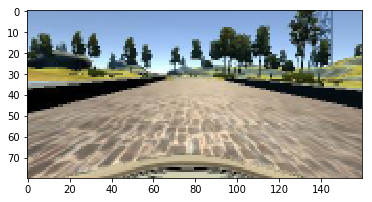

In [13]:
#making sure generator is fine
print("images",len(images))#passed
print("measures",len(measures))#passed
print("measures ex:",measures[len(measures)-1])#passed
print("loading test image..")    
#passed using : image = cv2.imread(source_path)
#passed using : image = cv2.imread(current_path)
#cv2.imshow("check",images[0])
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
#cv_rgb = cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB)
plt.imshow(images[0])
plt.show()

In [14]:
_time = time.time()
X_train = np.array(images)
y_train = np.array(measures)
print("_time ",(time.time() - _time))

_time  0.3182103633880615


In [15]:
#checkpoint :
_time = time.time()
X_train_test = X_train
y_train_test = y_train
print("_time ",(time.time() - _time))

_time  0.0


In [16]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, MaxPooling2D, Conv2D, Cropping2D, Dropout

Using TensorFlow backend.


In [17]:
_time = time.time()
#ch, row, col = 3, 80, 320  # Trimmed image format
ch, row, col = 3, 160*.5, 320*.5  # Trimmed image format
#model :
model = Sequential()
#normalize and mean center
model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape=(row,col,ch)))# output(None, 80, 160, 3)
model.add(Cropping2D(cropping=((35,12), (1,1)), input_shape=(row,col,ch)))# output (None, 33, 160, 3) 
#NVidia
model.add(Conv2D(16,(3, 3), input_shape=(33, 158, 3), activation='relu'))
#model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32,(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64,(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))


model.summary()

print("_time ",(time.time() - _time))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 80, 160, 3)        0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 33, 158, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 156, 16)       448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 78, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 76, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 38, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 36, 64)         18496     
__________

In [24]:
from keras.optimizers import Adam

_time = time.time()

#train
model.compile(loss='mse', optimizer=Adam(lr=0.1))
hist = model.fit(X_train_test, y_train_test, validation_split=0.2, shuffle=True, epochs=5, verbose=1)
#hist = model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=10)
#hist = model.fit_generator(train_generator, steps_per_epoch=len(train_samples)/BATCH_SIZE, validation_data=validation_generator, validation_steps=len(validation_samples)/BATCH_SIZE, epochs=5)
#hist = model.fit_generator(train_generator, steps_per_epoch=len(train_samples)/batch_size)

#hist = model.fit_generator(train_generator,steps_per_epoch=200, validation_steps=30, epochs=3,validation_data=validation_generator)
print("_time ",(time.time() - _time))


Train on 12857 samples, validate on 3215 samples
Epoch 1/5
12857/12857 [==============================] - 191s - loss: 0.0199 - val_loss: 0.0186

{'val_acc': [0.55147744945567656, 0.55147744945567656, 0.55147744945567656, 0.55147744945567656, 0.55147744945567656], 'loss': [1300810.8446822485, 0.02059991926649055, 0.020759139898137283, 0.02258445388648566, 0.017023778561016788], 'acc': [0.51870576340896102, 0.54048378311605838, 0.54025044719010362, 0.54040600451579723, 0.5404837831485102], 'val_loss': [0.045258694301427434, 0.018328129039776059, 0.037340409651653576, 0.016732872015813846, 0.01684613522238762]}


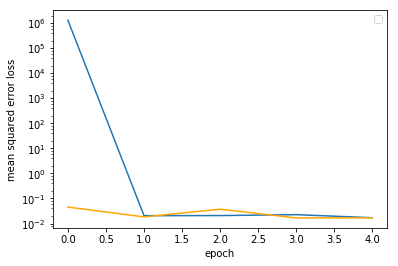

In [20]:
print(hist.history)
#plt.plot(history['loss'])
#plt.plot(history['val_loss'])
#plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.semilogy(hist.history['loss'])
plt.semilogy(hist.history['val_loss'],color='orange')
plt.show()

In [25]:
#save
model.save('model_.h5')

In [ ]:
#checkpoint--------------------------------------
#load
from keras.models import load_model
continue_model = load_model('model.h5')

In [ ]:
continue_model.compile(loss='mse', optimizer='adam')
continue_model.fit(X_train_test, y_train_test, validation_split=0.2, shuffle=True, epochs=4, verbose=1)

In [32]:
del model